# Self-Calibrated Variance-Stabilizing Transformations for Real-World Image Denoising

## Sébastien Herbreteau and Michael Unser

#### Import libraries

In [9]:
import torch
import numpy as np
import urllib.request
import sys

sys.path.insert(0, "src")

from noise2vst.models.ffdnet import FFDNet
from noise2vst.models.drunet import DRUNet
from noise2vst.models.noise2vst import Noise2VST
from noise2vst.utilities.utilities import *

#### Download and load pre-trained weights 

We use two popular off-the-shelf neural networks:
 - **FFDNet** [K. Zhang et al., IEEE Trans IP 2018]
 - **DRUNet** [K. Zhang et al., IEEE Trans PAMI 2022]
  
These models are specialized in the removal of **Gaussian noise**, with $\sigma=25/255$ by default.

**Download:**

In [10]:
url = "https://github.com/cszn/KAIR/releases/download/v1.0/"
for model in ["ffdnet_gray.pth", "ffdnet_color.pth", "drunet_gray.pth", "drunet_color.pth"]:
    urllib.request.urlretrieve(url + model, "./src/noise2vst/pretrained_weights/" + model)

**Load:**

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# FFDNet
m_ffdnet_gray = FFDNet(color=False).to(device).requires_grad_(False)
m_ffdnet_gray.load_state_dict(torch.load("./src/noise2vst/pretrained_weights/ffdnet_gray.pth", map_location=device, weights_only=True), strict=True)

m_ffdnet_color = FFDNet(color=True).to(device).requires_grad_(False)
m_ffdnet_color.load_state_dict(torch.load("./src/noise2vst/pretrained_weights/ffdnet_color.pth", map_location=device, weights_only=True), strict=True)

# DRUNet
m_drunet_gray = DRUNet(color=False).to(device).requires_grad_(False)
m_drunet_gray.load_state_dict(torch.load("./src/noise2vst/pretrained_weights/drunet_gray.pth", map_location=device, weights_only=True), strict=True)

m_drunet_color = DRUNet(color=True).to(device).requires_grad_(False)
m_drunet_color.load_state_dict(torch.load("./src/noise2vst/pretrained_weights/drunet_color.pth", map_location=device, weights_only=True), strict=True)

<All keys matched successfully>

## Synthetic noise

The noise model is $$z_i = \mathcal{P}(\lambda s_i) / \lambda\,,$$
with $\lambda=50$.

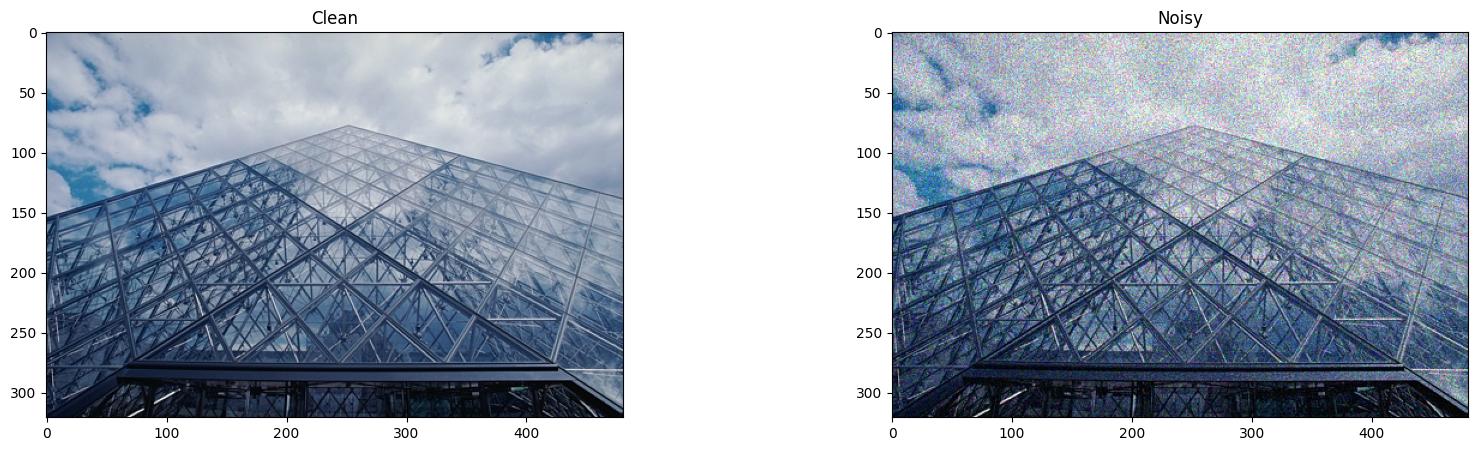

In [12]:
# Read clean image 
img_clean = load_img("./test_images/223061.jpg").to(device)

# Add artificial Poisson noise
lam = 50
img_noisy = torch.poisson(img_clean * lam) / lam

# Display
show_img([img_clean, img_noisy], titles=["Clean", "Noisy"], color=True)

#### GAT denoising

In [13]:
a, b = 1/lam, 0.0
target_sigma = 25/255

img_den_GAT = f_GAT_inv(m_drunet_color(f_GAT(img_noisy, a, b, target_sigma)), a, b, target_sigma)

#### Noise2VST denoising

**Note:** contrary to the GAT approach, Noise2VST does not assume any noise model.

In [14]:
# Instanciate the class
noise2VST = Noise2VST().to(device)

# Training (time depends on the performance of your CPU/GPU)
noise2VST.fit(img_noisy, m_ffdnet_color, nb_iterations=2000)

# Inference
with torch.no_grad():
    img_den_N2VST = noise2VST(img_noisy, m_drunet_color)

#### Display

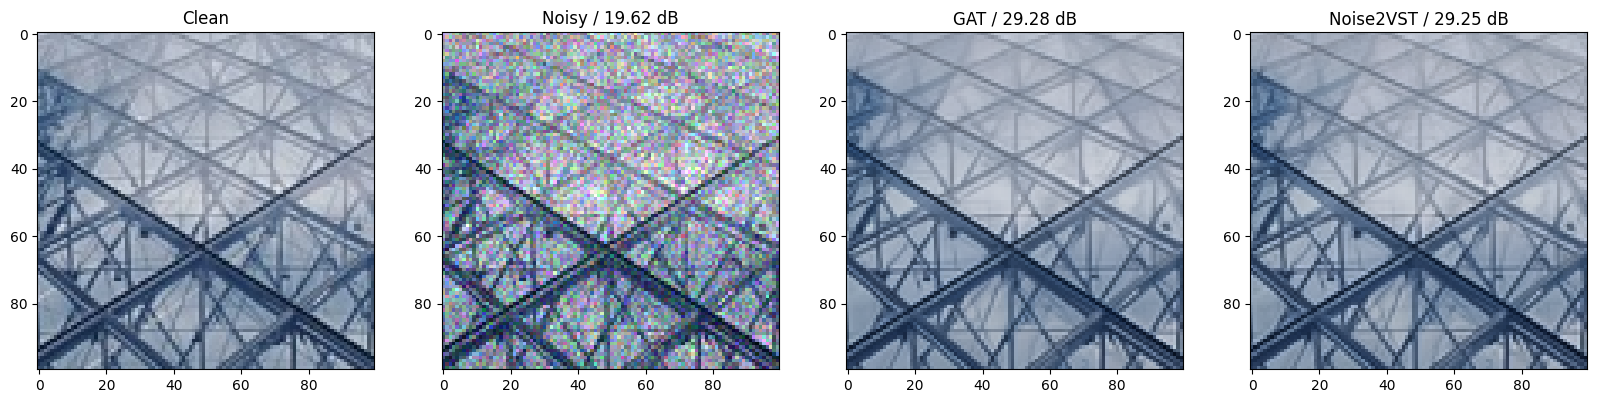

In [15]:
zoom_clean = img_clean[..., 100:200, 200:300]
zoom_noisy = img_noisy[..., 100:200, 200:300]
zoom_den_GAT = img_den_GAT[..., 100:200, 200:300]
zoom_den_N2VST = img_den_N2VST[..., 100:200, 200:300]

psnr_noisy = str(np.round(psnr(zoom_clean, zoom_noisy), 2)) + " dB"
psnr_GAT = str(np.round(psnr(zoom_clean, zoom_den_GAT), 2)) + " dB"
psnr_N2VST = str(np.round(psnr(zoom_clean, zoom_den_N2VST), 2)) + " dB"

show_img([zoom_clean, zoom_noisy, zoom_den_GAT, zoom_den_N2VST], titles=["Clean" , "Noisy / " + psnr_noisy, "GAT / " + psnr_GAT, "Noise2VST / " + psnr_N2VST], color=True)

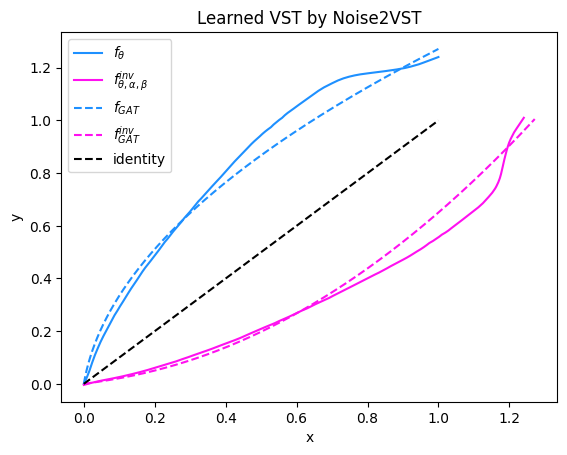

In [16]:
# Display the learned VST
display_vst(noise2VST, ab_GAT=(a, b))

## Real-world noise

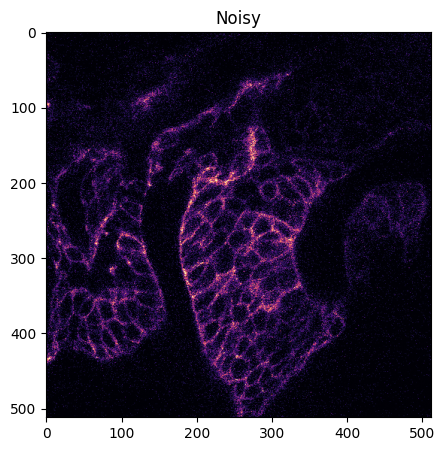

In [17]:
# Read noisy image 
img_noisy = load_img("./test_images/HV140_P100510016.png").to(device)

# Display
show_img([img_noisy], titles=["Noisy"], color=False)

#### GAT denoising

**Note:** the GAT parameters are taken from Y. Zhang et al., "A poisson-gaussian denoising dataset with real fluorescence microscopy images", CVPR 2019.

In [18]:
a, b = 9.43e-2, 0.0
target_sigma = 25/255

img_den_GAT = f_GAT_inv(m_drunet_gray(f_GAT(img_noisy, a, b, target_sigma)), a, b, target_sigma)

#### Noise2VST denoising

In [19]:
# Instanciate the class
noise2VST = Noise2VST().to(device)

# Training (time depends on the performance of your CPU/GPU)
noise2VST.fit(img_noisy, m_ffdnet_gray, nb_iterations=2000)

# Inference
with torch.no_grad():
    img_den_N2VST = noise2VST(img_noisy, m_drunet_gray)

#### Display

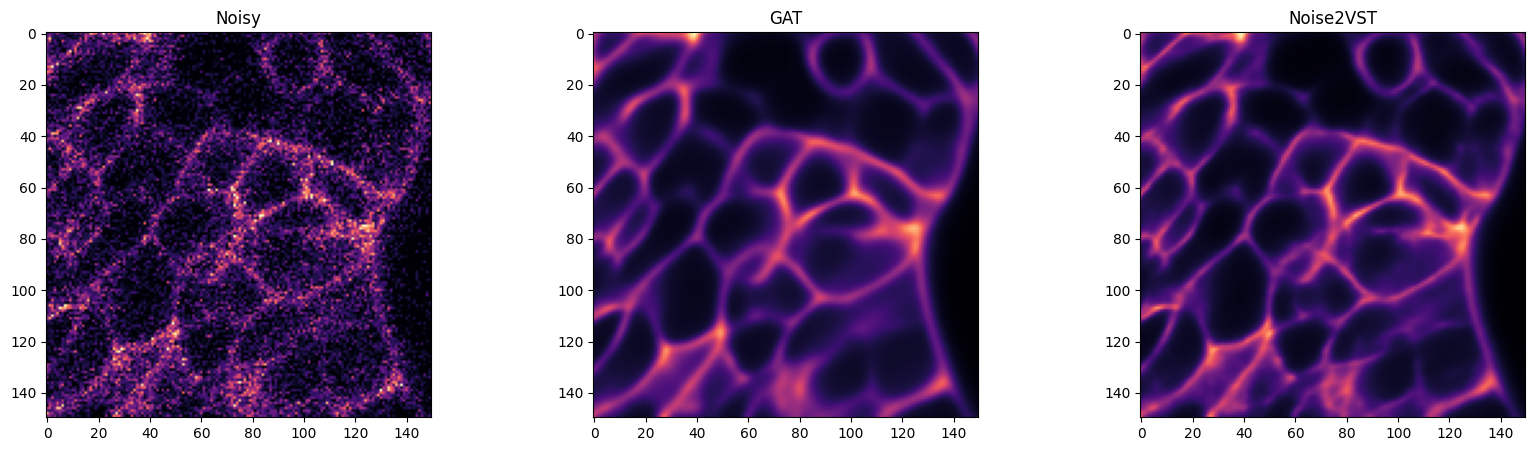

In [20]:
zoom_noisy = img_noisy[..., 200:350, 200:350]
zoom_den_GAT = img_den_GAT[..., 200:350, 200:350]
zoom_den_N2VST = img_den_N2VST[..., 200:350, 200:350]
show_img([zoom_noisy, zoom_den_GAT, zoom_den_N2VST], titles=["Noisy", "GAT", "Noise2VST"], color=False)

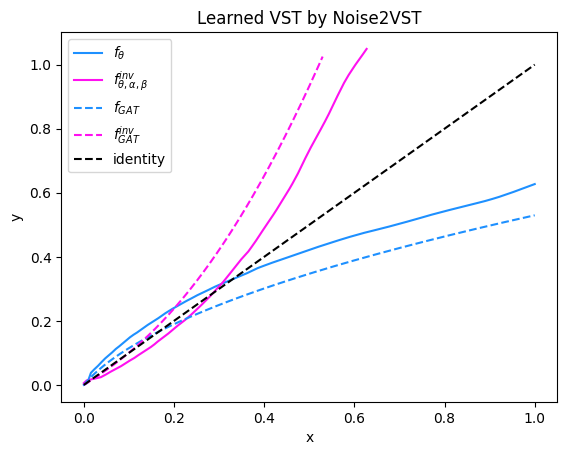

In [21]:
# Display the learned VST
display_vst(noise2VST, ab_GAT=(a, b))